In [4]:
import os
import requests

from fashion_clip.fashion_clip import FashionCLIP, FCLIPDataset
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation

import matplotlib.pyplot as plt
from PIL import Image

import torch.nn as nn
import torchvision.transforms as transforms

img = Image.open('C:/Users/Alex/Pictures/hank_jpg.jpg')

img_tensor = transforms.ToTensor()(img)#.unsqueeze(0)
print(img_tensor.shape)

fclip = FashionCLIP('fashion-clip')

image_embeddings_img = fclip.encode_images([img], 1)
image_embeddings_str = fclip.encode_images(['C:/Users/Alex/Pictures/alex_thumbnail.jpg'], 1)

image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)

print(image_embeddings_img.shape)
print(image_embeddings_str.shape)

torch.Size([3, 1000, 1000])


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]

(1, 512)
(1, 512)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1500 at 0x26F840141D0>
torch.Size([1500, 1000])
tensor([ 0,  2,  4,  6, 11, 15, 16])


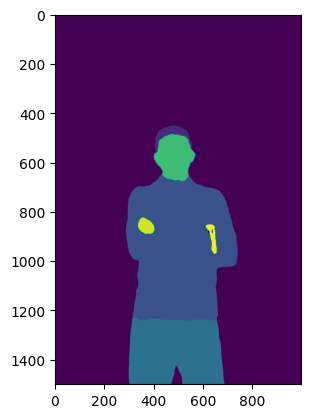

In [8]:


extractor = AutoFeatureExtractor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"

image = Image.open(requests.get(url, stream=True).raw)
print(image)
inputs = extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
print(pred_seg.shape)
print(pred_seg.unique())
plt.imshow(pred_seg)

In [15]:

old_map = {
   "Background": 0,
   "Bag": 16,
   "Belt": 8,
   "Dress": 7,
   "Face": 11,
   "Hair": 2,
   "Hat": 1,
   "Left-arm": 14,
   "Left-leg": 12,
   "Left-shoe": 9,
   "Pants": 6,
   "Right-arm": 15,
   "Right-leg": 13,
   "Right-shoe": 10,
   "Scarf": 17,
   "Skirt": 5,
   "Sunglasses": 3,
   "Upper-clothes": 4
} # we only need to process through some of these keys - and can merge shoes, etc?

key_map = {v: k for k, v in old_map.items()}


just loaded torch.Size([3, 1280, 960])
out of segmentation torch.Size([1500, 1000])
tensor([ 0,  2,  4,  6,  8, 11, 14, 15])
['Background', 'Hair', 'Upper-clothes', 'Pants', 'Belt', 'Face', 'Left-arm', 'Right-arm']


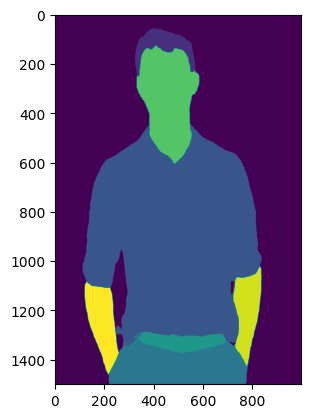

['Background', 'Upper-clothes', 'Pants', 'Belt']


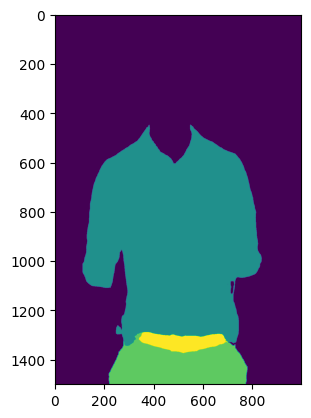

 torch.Size([3, 1500, 1000])
temp shape torch.Size([3, 1500, 1000])
mask shape torch.Size([1500, 1000])


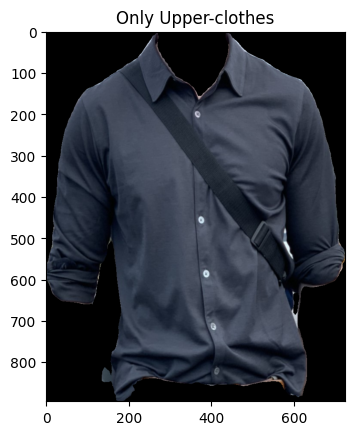

torch.Size([3, 895, 724])


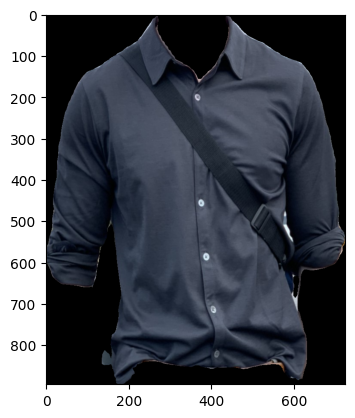

temp shape torch.Size([3, 1500, 1000])
mask shape torch.Size([1500, 1000])


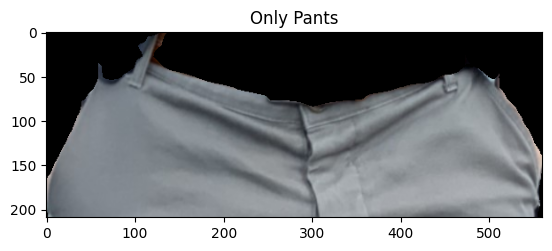

torch.Size([3, 209, 560])


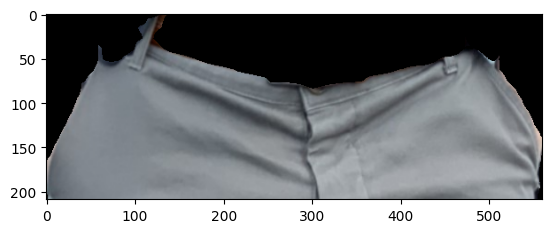

temp shape torch.Size([3, 1500, 1000])
mask shape torch.Size([1500, 1000])


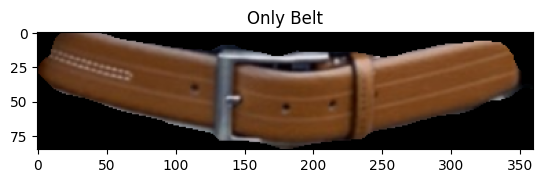

torch.Size([3, 85, 360])


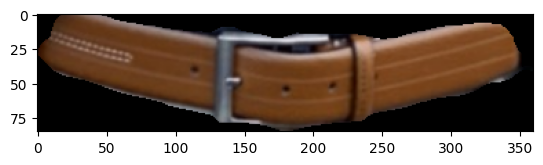

In [56]:

from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
import torch

# Load an image
img = Image.open('C:/Users/Alex/Pictures/alex_thumbnail.jpg')
img_tensor = transforms.ToTensor()(img)
print('just loaded', img_tensor.shape)

# Segment image
inputs = extractor(images=img, return_tensors="pt")

with torch.no_grad(): outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

mask = upsampled_logits.argmax(dim=1)[0]
print('out of segmentation', mask.shape)
print(mask.unique())
print([key_map[x] for x in mask.unique().tolist()])
plt.imshow(mask)
plt.show()

# Make the segmentation map relevant by removing unneeded features:
def relevant_map(mask):
    # make the mask relevant by merging features
    # let's just have this return a mask with only clothing
    
    mask[mask == 10] = 9 # Right shoes become left shoes
    
    # Remove then following:
    mask[mask == 11] = 0 # face
    mask[mask == 2] = 0 # hair
    mask[mask == 14] = 0 # left arm
    mask[mask == 12] = 0 # left leg
    mask[mask == 15] = 0 # right arm
    mask[mask == 13] = 0 # right leg
    return mask
    
mask = relevant_map(mask)
print([key_map[x] for x in mask.unique().tolist()])
plt.imshow(mask)
plt.show()
    
# Using segmentation map, great image into subimages
obj_ids = mask.unique()
masks = torch.BoolTensor(mask == obj_ids[:,None, None])
boxes = masks_to_boxes(masks)

subims = []
subids = []

resize = transforms.Resize((1500,1000))
to_image = transforms.ToPILImage()

image_tensor = resize(transforms.ToTensor()(img))
print('', image_tensor.shape)

for obind, obid in enumerate(obj_ids):
    if obid != 0:
        temp = image_tensor.clone()
        print('temp shape', temp.shape)
        print('mask shape', mask.shape)
        temp[:,mask!=obid] = 0 # Set everything but current clothing item to 0

        xmin = int(boxes[obind, 0])
        ymin = int(boxes[obind, 1])
        xmax =int(boxes[obind, 2])
        ymax = int(boxes[obind, 3])

        subim = temp[:, ymin:ymax, xmin:xmax]
        #subim = resize(subim)

        plt.imshow(subim.squeeze().permute(1,2,0))
        plt.title(f'Only {key_map[obid.item()]}')
        plt.show()
    
        print(subim.shape)
        subim = to_image(subim)
        plt.imshow(subim)
        plt.show()
        subims.append(subim) # I think we need them in image format for Clip
        subids.append(obid)



In [64]:
# We now have a list of item images. embed these
image_embeddings_batch = fclip.encode_images(subims, len(subims))
image_embeddings_batch = image_embeddings_batch/np.linalg.norm(image_embeddings_batch, ord=2, axis=-1, keepdims=True)

print(image_embeddings_batch.shape)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]

(3, 512)


In [65]:
print(dir(fclip))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_cosine_similarity', '_generate_vectors', '_get_heatmap', '_load_model', '_nearest_neighbours', 'approx', 'dataset', 'device', 'display_attention', 'encode_images', 'encode_text', 'model', 'model_hash', 'model_name', 'preprocess', 'retrieval', 'zero_shot_classification']


type mask tensor <class 'numpy.ndarray'>
(1280, 960) [4 6 8]
<class 'numpy.ndarray'> <class 'numpy.int64'>
temporary image size: torch.Size([3, 1280, 960])
comared to mask size (1280, 960)


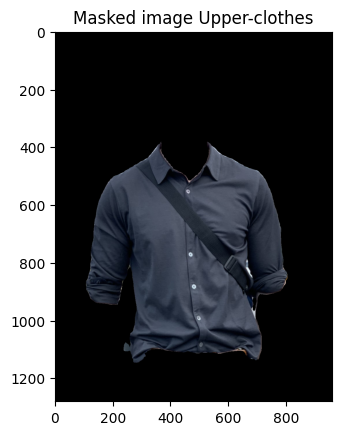

enumerating obj_ids [4 6 8]
obind, obid, code 0 4 4
obind, obid, code 1 6 4
obind, obid, code 2 8 4


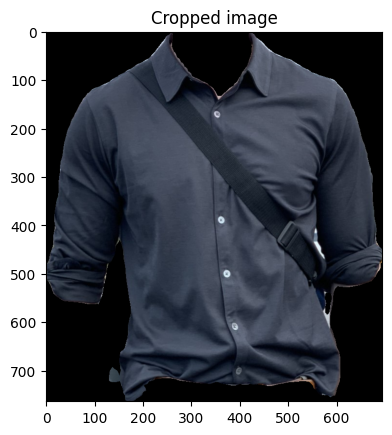

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]

This item emebdded to (1, 512)


(4,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x1280>,
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [2]:
import bot_utils_2 as butils2
#import bot_utils as butils
from PIL import Image


#butils.add_item_to_database(img = Image.open('C:/Users/Alex/Pictures/hank_jpg.jpg'), name = 'samplename', price = 99)
butils2.add_item_to_database(img = Image.open('C:/Users/Alex/Pictures/alex_thumbnail.jpg'))

C:\Users\Alex\Documents\cloth-segmentation/database/1\0emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\10emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\11emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\12emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\13emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\14emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\15emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\16emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\17emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\18emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\19emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\1emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\20emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\21emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\22emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\23e

C:\Users\Alex\Documents\cloth-segmentation/database/1\17\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\17\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\17\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\17\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\18\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\18\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/1\18
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/1\18\img.pt
item name, price cute tank top 84
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/1\18\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\18\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\18\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\18\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\19\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\19\img.pt
dire C:\Use

C:\Users\Alex\Documents\cloth-segmentation/database/1\3\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\3\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\3\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\3\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\30\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\30\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/1\30
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/1\30\img.pt
item name, price shirt 540
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/1\30\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\30\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\30\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\30\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\31\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\31\img.pt
dire C:\Users\Alex\Doc

C:\Users\Alex\Documents\cloth-segmentation/database/1\42\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\42\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\42\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\42\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\43\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\43\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/1\43
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/1\43\img.pt
item name, price womanly 500
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/1\43\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\43\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\43\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\43\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\44\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\44\img.pt
dire C:\Users\Al

C:\Users\Alex\Documents\cloth-segmentation/database/1\55\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\55\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\55\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\55\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\56\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\56\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/1\56
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/1\56\img.pt
item name, price  shirt 20
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/1\56\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\56\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\56\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\56\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\57\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\57\img.pt
dire C:\Users\Alex

C:\Users\Alex\Documents\cloth-segmentation/database/1\68\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\68\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\68\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\68\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\69\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\69\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/1\69
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/1\69\img.pt
item name, price  guy 200
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/1\69\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\69\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\69\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\69\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\7\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/1\7\img.pt
dire C:\Users\Alex\Do

C:\Users\Alex\Documents\cloth-segmentation/database/2\12\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\12\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\12\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\12\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\13\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\13\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\13
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\13\img.pt
item name, price Wrangler Mens Cargo Pant 35
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/2\13\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\13\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\13\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\13\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\14\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\14\img.pt


C:\Users\Alex\Documents\cloth-segmentation/database/2\25\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\25\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\25\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\25\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\26\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\26\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\26
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\26\img.pt
item name, price Vineyard Vines Men's Short 85
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/2\26\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\26\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\26\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\26\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\27\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\27\img.p

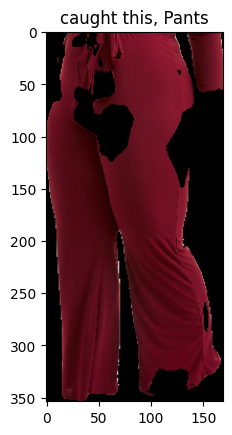

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.31it/s]


database2/Pants/red pants/
C:\Users\Alex\Documents\cloth-segmentation/database/2\37\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\37\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\37\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\37\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\38\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\38\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\38
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\38\img.pt
item name, price mickey mouse trousers 24
<class 'PIL.Image.Image'>


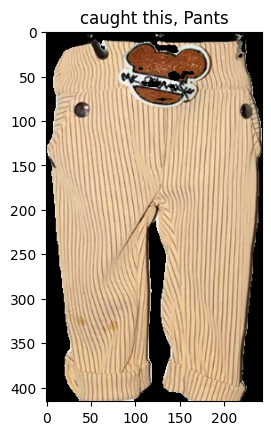

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.07it/s]


database2/Pants/mickey mouse trousers/
C:\Users\Alex\Documents\cloth-segmentation/database/2\38\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\38\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\38\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\38\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\39\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\39\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\39
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\39\img.pt
item name, price ripped shorts 45
<class 'PIL.Image.Image'>


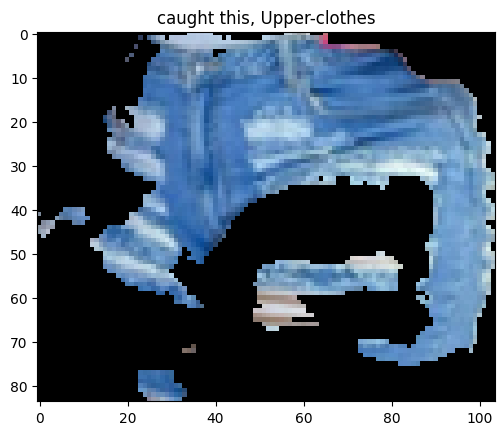

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.64it/s]


database2/Upper-clothes/ripped shorts/
C:\Users\Alex\Documents\cloth-segmentation/database/2\39\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\39\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\39\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\39\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\4\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\4\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\4
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\4\img.pt
item name, price Dickes 40
<class 'PIL.Image.Image'>


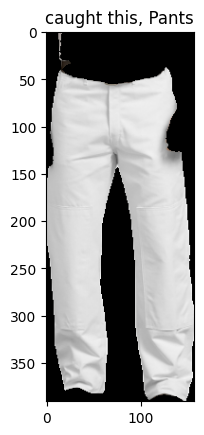

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


database2/Pants/Dickes/
C:\Users\Alex\Documents\cloth-segmentation/database/2\4\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\4\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\4\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\4\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\40\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\40\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\40
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\40\img.pt
item name, price  pant 2
<class 'PIL.Image.Image'>


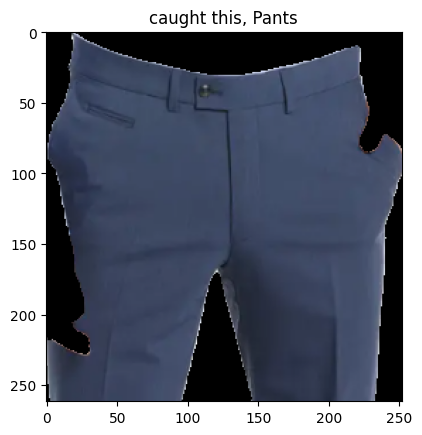

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.82it/s]


database2/Pants/ pant/
C:\Users\Alex\Documents\cloth-segmentation/database/2\40\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\40\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\40\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\40\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\41\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\41\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\41
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\41\img.pt
item name, price  pants 200
<class 'PIL.Image.Image'>


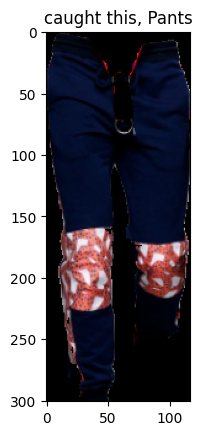

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.25it/s]


database2/Pants/ pants/
C:\Users\Alex\Documents\cloth-segmentation/database/2\41\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\41\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\41\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\41\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\42\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\42\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\42
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\42\img.pt
item name, price  cute shorts 5
<class 'PIL.Image.Image'>


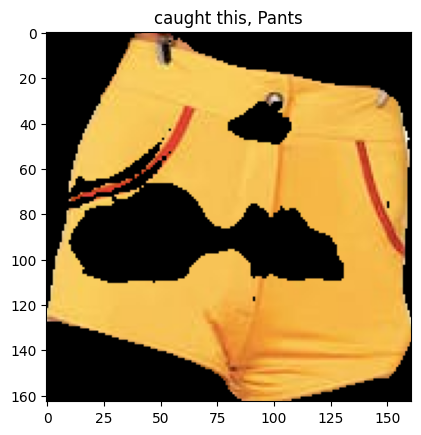

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]


database2/Pants/ cute shorts/
C:\Users\Alex\Documents\cloth-segmentation/database/2\42\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\42\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\42\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\42\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\5\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\5\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\5
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\5\img.pt
item name, price Fox 40
<class 'PIL.Image.Image'>


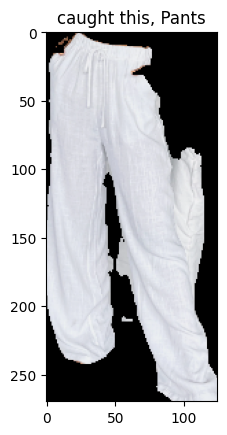

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.07it/s]


database2/Pants/Fox/
C:\Users\Alex\Documents\cloth-segmentation/database/2\5\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\5\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\5\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\5\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\6\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\6\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\6
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\6\img.pt
item name, price Gap 65
<class 'PIL.Image.Image'>


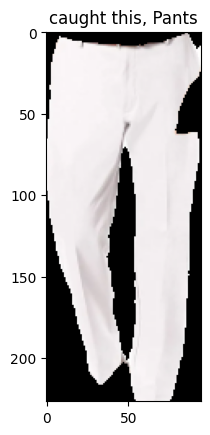

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.75it/s]


database2/Pants/Gap/
C:\Users\Alex\Documents\cloth-segmentation/database/2\6\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\6\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\6\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\6\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\7\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\7\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\7
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\7\img.pt
item name, price PurpleJeans 69.99
<class 'PIL.Image.Image'>


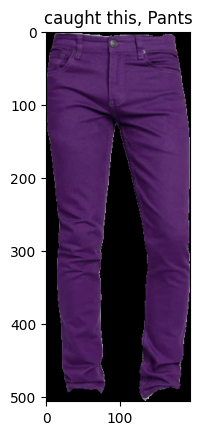

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


database2/Pants/PurpleJeans/
C:\Users\Alex\Documents\cloth-segmentation/database/2\7\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\7\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\7\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\7\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\8\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\8\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/2\8
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/2\8\img.pt
item name, price gap 30
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/2\8\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\8\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\8\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\8\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\9\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/2\9\img.pt
dire C

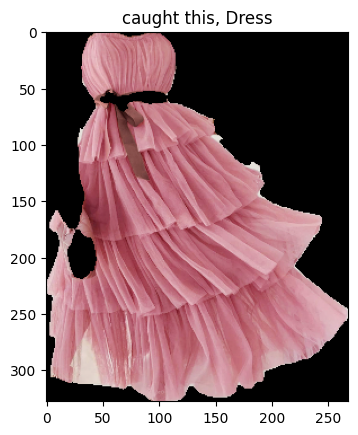

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.62it/s]


database2/Dress/Azazie/
C:\Users\Alex\Documents\cloth-segmentation/database/3\0\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\0\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\0\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\0\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\1\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\1\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\1
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\1\img.pt
item name, price gap 40
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/3\1\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\1\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\1\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\1\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\10\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\10\img.pt
dire C:\U

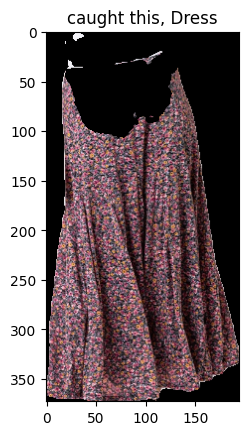

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


database2/Dress/Midi & Maxi Roman Skirt/
C:\Users\Alex\Documents\cloth-segmentation/database/3\10\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\10\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\10\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\10\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\11\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\11\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\11
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\11\img.pt
item name, price fighter torso 60000000
<class 'PIL.Image.Image'>
C:\Users\Alex\Documents\cloth-segmentation/database/3\11\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\11\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\11\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\11\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\12\centroid.pt
C:\Users\Alex\Documents\clot

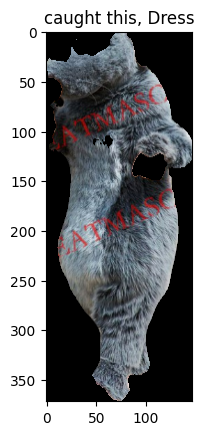

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.90it/s]


database2/Dress/rat attack/
C:\Users\Alex\Documents\cloth-segmentation/database/3\12\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\12\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\12\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\12\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\13\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\13\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\13
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\13\img.pt
item name, price very blue guy 100
<class 'PIL.Image.Image'>


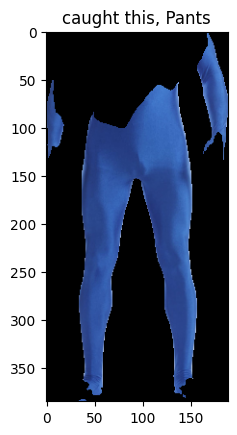

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.62it/s]


database2/Pants/very blue guy/
C:\Users\Alex\Documents\cloth-segmentation/database/3\13\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\13\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\13\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\13\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\14\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\14\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\14
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\14\img.pt
item name, price alaskan wiener 300
<class 'PIL.Image.Image'>


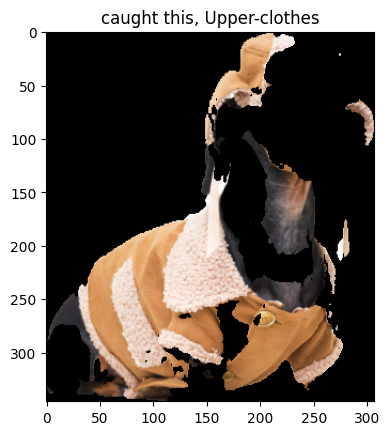

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.87it/s]


database2/Upper-clothes/alaskan wiener/
C:\Users\Alex\Documents\cloth-segmentation/database/3\14\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\14\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\14\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\14\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\15\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\15\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\15
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\15\img.pt
item name, price cat cowboy 100
<class 'PIL.Image.Image'>


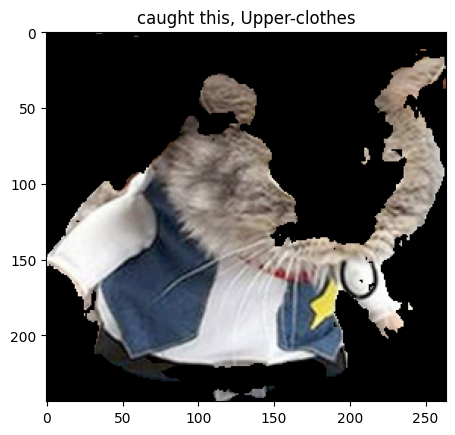

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]


database2/Upper-clothes/cat cowboy/
C:\Users\Alex\Documents\cloth-segmentation/database/3\15\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\15\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\15\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\15\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\16\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\16\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\16
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\16\img.pt
item name, price awesome cat 16
<class 'PIL.Image.Image'>


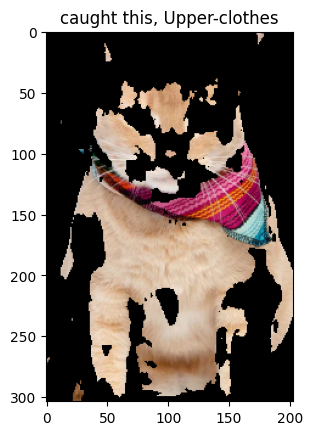

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.36it/s]


database2/Upper-clothes/awesome cat/
C:\Users\Alex\Documents\cloth-segmentation/database/3\16\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\16\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\16\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\16\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\17\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\17\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\17
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\17\img.pt
item name, price they hit the second tower 911
<class 'PIL.Image.Image'>


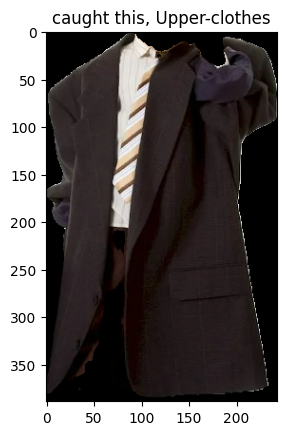

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.79it/s]


database2/Upper-clothes/they hit the second tower/
C:\Users\Alex\Documents\cloth-segmentation/database/3\17\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\17\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\17\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\17\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\18\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\18\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\18
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\18\img.pt
item name, price id wear it 150
<class 'PIL.Image.Image'>


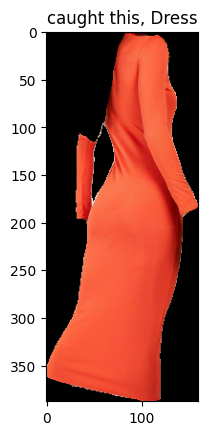

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.97it/s]


database2/Dress/id wear it/
C:\Users\Alex\Documents\cloth-segmentation/database/3\18\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\18\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\18\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\18\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\19\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\19\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\19
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\19\img.pt
item name, price red skirt 25
<class 'PIL.Image.Image'>


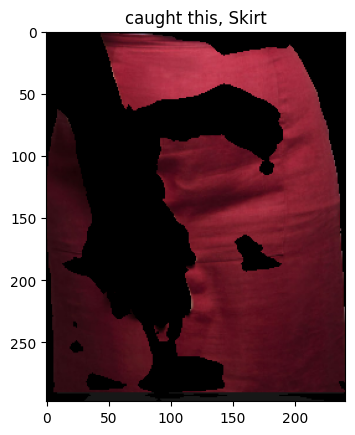

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.84it/s]


database2/Skirt/red skirt/
C:\Users\Alex\Documents\cloth-segmentation/database/3\19\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\19\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\19\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\19\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\2\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\2\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\2
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\2\img.pt
item name, price easter sweater 100
<class 'PIL.Image.Image'>


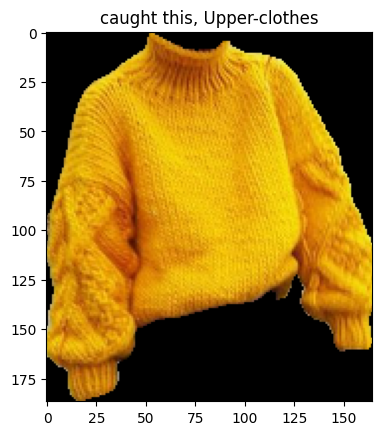

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.66it/s]


database2/Upper-clothes/easter sweater/
C:\Users\Alex\Documents\cloth-segmentation/database/3\2\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\2\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\2\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\2\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\20\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\20\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\20
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\20\img.pt
item name, price warrior 1800
<class 'PIL.Image.Image'>


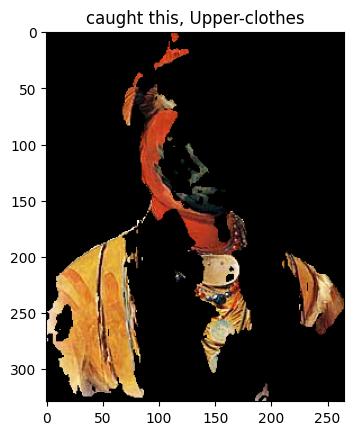

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.52it/s]


database2/Upper-clothes/warrior/
C:\Users\Alex\Documents\cloth-segmentation/database/3\20\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\20\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\20\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\20\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\21\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\21\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\21
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\21\img.pt
item name, price  givenchy dress 20
<class 'PIL.Image.Image'>


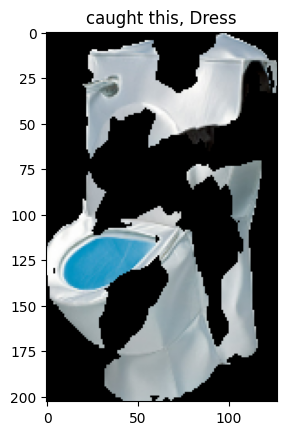

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.12it/s]


database2/Dress/ givenchy dress/
C:\Users\Alex\Documents\cloth-segmentation/database/3\21\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\21\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\21\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\21\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\22\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\22\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\22
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\22\img.pt
item name, price  sunflower suit 100
<class 'PIL.Image.Image'>


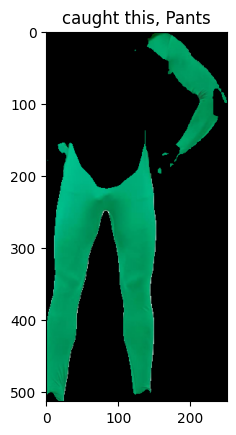

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.19it/s]


database2/Pants/ sunflower suit/
C:\Users\Alex\Documents\cloth-segmentation/database/3\22\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\22\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\22\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\22\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\23\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\23\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\23
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\23\img.pt
item name, price  monkey 25
<class 'PIL.Image.Image'>


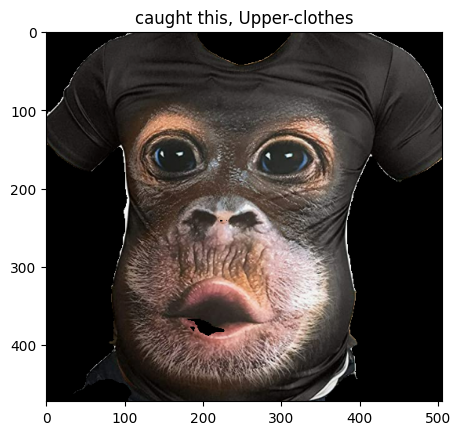

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.64it/s]


database2/Upper-clothes/ monkey/
C:\Users\Alex\Documents\cloth-segmentation/database/3\23\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\23\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\23\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\23\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\24\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\24\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\24
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\24\img.pt
item name, price  wizard suit 25
<class 'PIL.Image.Image'>


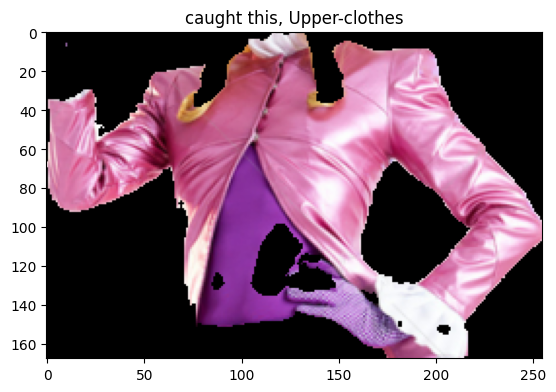

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


database2/Upper-clothes/ wizard suit/
C:\Users\Alex\Documents\cloth-segmentation/database/3\24\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\24\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\24\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\24\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\3\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\3\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\3
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\3\img.pt
item name, price parachute pants 400
<class 'PIL.Image.Image'>


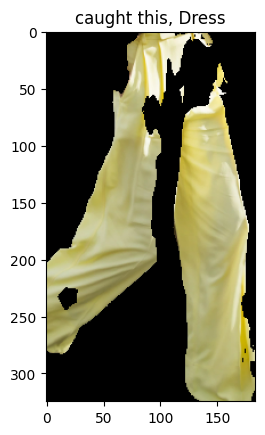

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


database2/Dress/parachute pants/
C:\Users\Alex\Documents\cloth-segmentation/database/3\3\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\3\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\3\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\3\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\4\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\4\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\4
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\4\img.pt
item name, price metal chestplate 5000
<class 'PIL.Image.Image'>


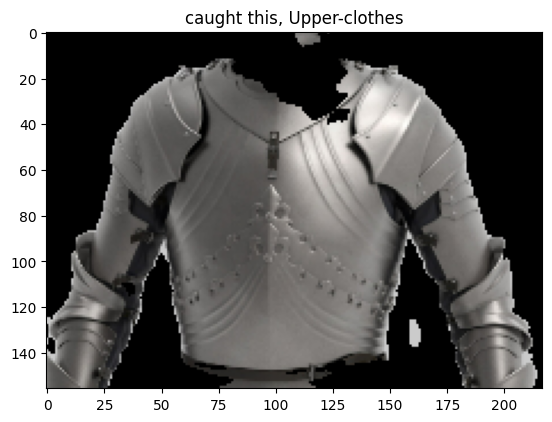

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.95it/s]


database2/Upper-clothes/metal chestplate/
C:\Users\Alex\Documents\cloth-segmentation/database/3\4\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\4\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\4\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\4\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\5\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\5\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\5
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\5\img.pt
item name, price man dress 65
<class 'PIL.Image.Image'>


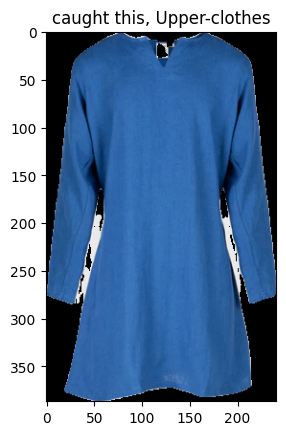

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.66it/s]


database2/Upper-clothes/man dress/
C:\Users\Alex\Documents\cloth-segmentation/database/3\5\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\5\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\5\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\5\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\6\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\6\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\6
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\6\img.pt
item name, price Garnet Hill 220
<class 'PIL.Image.Image'>


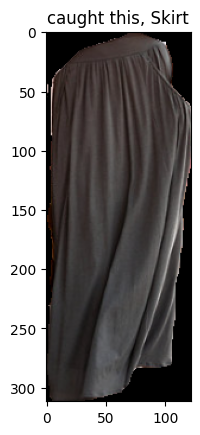

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.52it/s]


database2/Skirt/Garnet Hill/
C:\Users\Alex\Documents\cloth-segmentation/database/3\6\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\6\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\6\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\6\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\7\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\7\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\7
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\7\img.pt
item name, price Seasalt Cornwall Skirt 120
<class 'PIL.Image.Image'>


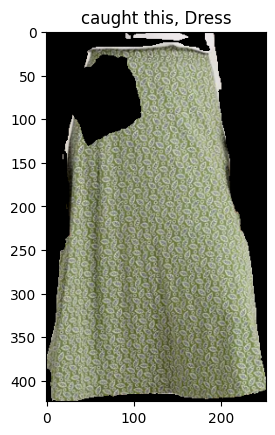

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.77it/s]


database2/Dress/Seasalt Cornwall Skirt/
C:\Users\Alex\Documents\cloth-segmentation/database/3\7\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\7\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\7\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\7\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\8\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\8\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\8
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\8\img.pt
item name, price Ann Taylor Pleated Skirt 220
<class 'PIL.Image.Image'>


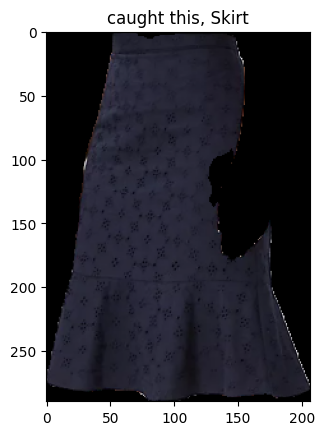

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.39it/s]


database2/Skirt/Ann Taylor Pleated Skirt/
C:\Users\Alex\Documents\cloth-segmentation/database/3\8\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\8\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\8\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\8\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\9\centroid.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\9\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/3\9
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/3\9\img.pt
item name, price peasant top 0.0001
<class 'PIL.Image.Image'>


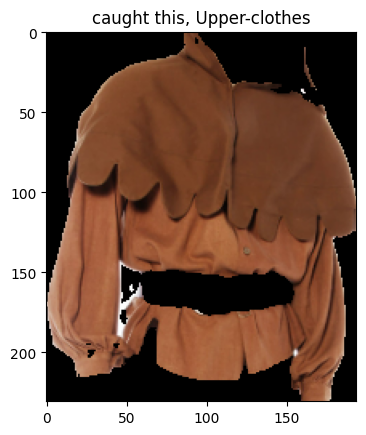

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


database2/Upper-clothes/peasant top/
C:\Users\Alex\Documents\cloth-segmentation/database/3\9\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\9\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\9\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/3\9\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/4\0\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/4\0
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/4\0\img.pt
item name, price  100
<class 'PIL.JpegImagePlugin.JpegImageFile'>


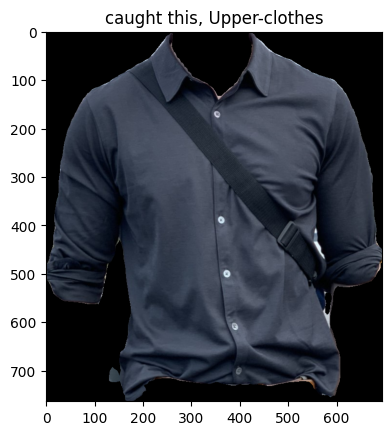

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


database2/Upper-clothes//
C:\Users\Alex\Documents\cloth-segmentation/database/4\0\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/4\0\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/4\0\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/4\0\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/4\1\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/4\1
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/4\1\img.pt
item name, price  100
<class 'PIL.WebPImagePlugin.WebPImageFile'>
C:\Users\Alex\Documents\cloth-segmentation/database/4\1\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/4\1\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/4\1\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/4\1\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/4\2\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/4\2
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/4\2\img

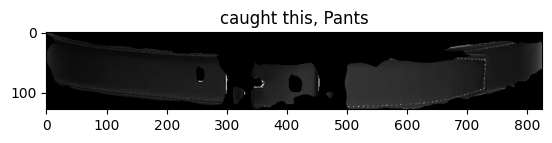

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


database2/Pants//
C:\Users\Alex\Documents\cloth-segmentation/database/6\0\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/6\0\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/6\0\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/6\0\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/6\1\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/6\1
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/6\1\img.pt
item name, price  100
<class 'PIL.WebPImagePlugin.WebPImageFile'>
C:\Users\Alex\Documents\cloth-segmentation/database/6\1\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/6\1\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/6\1\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/6\1\temp.pt
C:\Users\Alex\Documents\cloth-segmentation/database/7\0\img.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database/7\0
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database/7\0\img.pt
item

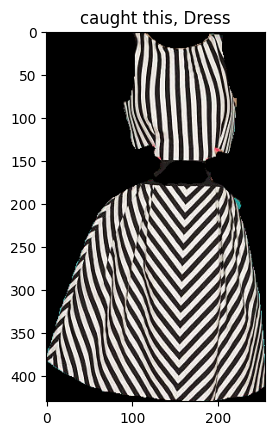

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]

database2/Dress//
C:\Users\Alex\Documents\cloth-segmentation/database/7\0\img_emb.pt
C:\Users\Alex\Documents\cloth-segmentation/database/7\0\name.pt
C:\Users\Alex\Documents\cloth-segmentation/database/7\0\price.pt
C:\Users\Alex\Documents\cloth-segmentation/database/7\0\temp.pt


In [4]:
# Correct the old embeddings database with new embeddings
import os
import torch
import matplotlib.pyplot as plt
import bot_utils_2 as butils2

# This code is to re-embed the old images
# But this means we also need to update the directories since we have different code types now!
if True:
    for path, subdirs, files in os.walk(os.getcwd() + '/database/'):
        for name in files:
            print(os.path.join(path, name))

            if 'img.pt' in os.path.join(path, name):

                dire = os.path.join(path, name)[:-7]
                print('dire', dire)
                print('loaded: ', os.path.join(path, name))
                
                item_name = torch.load(f'{dire}/name.pt')
                
                
                price = torch.load(f'{dire}/price.pt')

                print('item name, price', item_name, price)

                # Load the original image
                pil = torch.load(os.path.join(path, name))
                print(type(pil))

                # Make the subimage temp from the original image:
                temp, code, item_str = butils2.image_to_subims(pil, 'biggest')
                    
                if not os.path.isfile(f'database2/{item_str}/{item_name}/price.pt'):
                    plt.imshow(temp)
                    plt.title(f'caught this, {item_str}')
                    plt.show()

                    # Embed the iamge
                    emb = butils2.embed_image(temp)

                    ## Save the image, name, price, subim, emb to a NEW DIRECTORY!

                    # Get number of items in type directory
                    butils2.trymkdir(f'database2/{item_str}/')
                    dblist = os.listdir(f'database2/{item_str}/') # Go to subdirectory of item type
                    #item_id = len(dblist)
                    item_id = item_name

                    # Item directory
                    newdir = f'database2/{item_str}/{item_id}/'
                    print(newdir)
                    butils2.trymkdir(newdir)

                    # Save items
                    pil.save(f'{newdir}{item_name}_full_jpg.jpg')# Original image - pil
                    temp.save(f'{newdir}{item_name}_subim_jpg.jpg')# Scanned item cutout - pil
                    #torch.save(pil, f'{newdir}img.pt') 
                    #torch.save(temp, f'{newdir}temp.pt') 
                    torch.save(emb, f'{newdir}emb.pt') # Embedding of image - vector
                    torch.save(item_name, f'{newdir}item_name.pt') # Item string - str
                    torch.save(price, f'{newdir}price.pt') # Provided Price - float


C:\Users\Alex\Documents\cloth-segmentation/database2/Bag\Grandma Thanos\boxim.jpg
C:\Users\Alex\Documents\cloth-segmentation/database2/Bag\Grandma Thanos\emb.pt
dire C:\Users\Alex\Documents\cloth-segmentation/database2/Bag\Grandma Thanos
loaded:  C:\Users\Alex\Documents\cloth-segmentation/database2/Bag\Grandma Thanos\emb.pt
loading item name:  C:\Users\Alex\Documents\cloth-segmentation/database2/Bag\Grandma Thanos/item_name.pt
item name, price Grandma Thanos 200


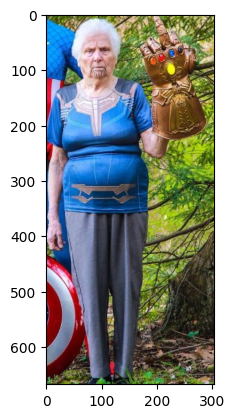

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [ ]:
# Go back and create boxims of everything

import os
import torch
import matplotlib.pyplot as plt
import bot_utils_2 as butils2
from PIL import Image

# This code is to re-embed the old images
# But this means we also need to update the directories since we have different code types now!
if True:
    for path, subdirs, files in os.walk(os.getcwd() + '/database2/'):
        for name in files:
            print(os.path.join(path, name))

            if 'emb.pt' in os.path.join(path, name):

                dire = os.path.join(path, name)[:-7]
                print('dire', dire)
                print('loaded: ', os.path.join(path, name))
                
                
                print('loading item name: ', f'{dire}/item_name.pt')
                item_name = torch.load(f'{dire}/item_name.pt')
                
                
                price = torch.load(f'{dire}/price.pt')

                print('item name, price', item_name, price)

                # Load the original image
                pil = Image.open(dire + f'/{item_name}_full_jpg.jpg')
                plt.imshow(pil)
                plt.show()
                
                print(type(pil))
                
                maskim, boxim, code, itemstr = butils2.image_to_subims(pil, 'biggest', debug = False)
                plt.imshow(maskim)
                plt.title(f'Subim, {code}, {itemstr}')
                plt.show()
                
                plt.imshow(boxim)
                plt.title(f'Boxim, {code}, {itemstr}')
                plt.show()
                
                
                boxim.save(f'{dire}/boxim.jpg')# Original image - pil
